# Transcription factor classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from itertools import product
from nn import nn, io, preprocess

## Data

In [2]:
rap1 = io.read_text_file("./data/rap1-lieb-positives.txt")
yeast = io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")

print("Length of Rap1 positives: " + str(len(rap1)))
print("Length of Yeast negatives: " + str(len(yeast)))

Length of Rap1 positives: 137
Length of Yeast negatives: 3163


In [3]:
pos_seq = rap1

# Break up yeast_neg into sizes match the length of rap1 sequences
seq_len = len(rap1[0])
neg_seq = []

for seq in yeast:
    seq_sub = [seq[i:i+seq_len] for i in range(0, len(seq), seq_len)]
    # Keep only sequences that are exactly rap length long
    seq_sub = [x for x in seq_sub if len(x) == seq_len]
    neg_seq += seq_sub

# Combine all sequences and get labes
seqs = pos_seq + neg_seq
labels = [True] * len(pos_seq) + [False] * len(neg_seq)

print("Length of positives: " + str(len(pos_seq)))
print("Length of negatives: " + str(len(neg_seq)))
print("Total sequences: " + str(len(pos_seq) + len(neg_seq)))

Length of positives: 137
Length of negatives: 183297
Total sequences: 183434


In [4]:
# Up sample the positive class
seqs2, labels2 = preprocess.sample_seqs(seqs, labels)
print("Length of positives: " + str(sum(labels2)))
print("Length of negatives: " + str(len(seqs2) - sum(labels2)))
print("Total sequences: " + str(len(seqs2)))

Length of positives: 183297
Length of negatives: 183297
Total sequences: 366594


In [5]:
# Encode sequences and create a training and testing split
X = preprocess.one_hot_encode_seqs(seqs2)
y = np.array(labels2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)
print("Training data " + str(X_train.shape))
print("Training labels " + str(y_train.shape))
print("Testing data " + str(X_val.shape))
print("Testing labels " + str(y_val.shape))


# X_train = X_train[1:200]
# y_train = y_train[1:200]
# X_val = X_val[1:100]
# y_val = y_val[1:100]

Training data (256615, 68)
Training labels (256615,)
Testing data (109979, 68)
Testing labels (109979,)


For this dataset, I chose to upsample the positive class to match the number of observations in the negative class. The primary reason for this is because neural networks tend to do better with a larger number of observations and having 274 total observations would not yield a productive neural network function.

## NN
Created a three layer neural network to go from the original 68 dimensions to a single classification outcome. Because it's a classification task, it made sense to use a sigmoid function for the final layer. The other parameters I chose purely out of convenience.

In [9]:
layers = [{"input_dim" : 68, "output_dim" : 34, "activation" : "sigmoid"},
          {"input_dim" : 34, "output_dim" : 17, "activation" : "sigmoid"},
          {"input_dim" : 17, "output_dim" : 1, "activation" : "sigmoid"}]

net = nn.NeuralNetwork(nn_arch = layers,
                       batch_size = 100,
                       epochs = 200,
                       lr = 0.001,
                       seed = 1,
                       loss_function = "bce",
                       verbose = True,
                       debug = True)

train_loss, val_loss = net.fit(X_train, y_train, X_val, y_val)

Epochs is greater than 1, setting debug to False
Number of batches: 2567.0
Finished epoch 1 out of 200
Finished epoch 21 out of 200
Finished epoch 41 out of 200
Finished epoch 61 out of 200
Finished epoch 81 out of 200
Finished epoch 101 out of 200
Finished epoch 121 out of 200
Finished epoch 141 out of 200
Finished epoch 161 out of 200
Finished epoch 181 out of 200
Completed NN fitting


Plot the training and validation losses

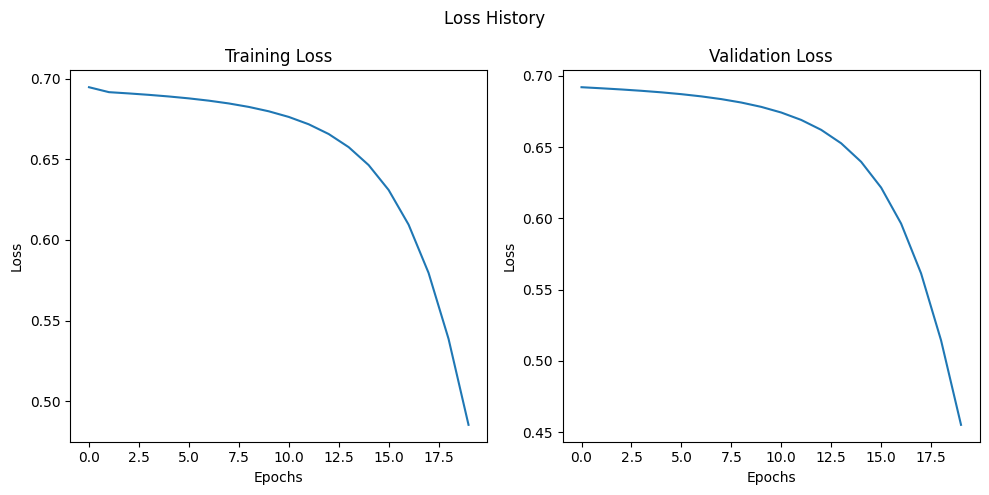

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(train_loss)), train_loss)
axs[0].set_title('Training Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Loss')
axs[1].plot(np.arange(len(val_loss)), val_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Loss')
fig.tight_layout()
plt.show() 

In [8]:
pred = net.predict(X_val)
pred_err = mean_squared_error(y_val, pred)
print("Average prediction error: " + str(round(pred_err, 4)))

Average prediction error: 0.1345
